<a href="https://colab.research.google.com/github/sahithii5104/FakeNewsDetection/blob/main/AI_Stock_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance


In [2]:
import yfinance as yf


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [4]:
# 1. Data Retrieval
ticker = 'AAPL'  # Change ticker for different companies
start_date = '2010-01-01'
end_date = '2023-12-31'

def get_data():
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close']]  # Use closing prices
    return data

stock_data = get_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# 2. Data Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data)


In [6]:
# 3. Create Training Dataset
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Use 60 days to predict next day
X, y = create_dataset(scaled_data, SEQ_LENGTH)

In [7]:
# 4. Train-Test Split (80-20 split)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# 5. Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 6. Train Model
history = model.fit(X_train, y_train,
                   batch_size=64,
                   epochs=50,
                   validation_data=(X_test, y_test))

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 6.8769e-04 - val_loss: 0.0015
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 5.1565e-04 - val_loss: 0.0016
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 4.5227e-04 - val_loss: 0.0011
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.2307e-04 - val_loss: 0.0025
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 4.7260e-04 - val_loss: 9.4611e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 4.1564e-04 - val_loss: 9.5007e-04
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.9399e-04 - val_loss: 8.6244e-04
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 3.5609e-04 - val_loss: 8.7843e-04
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 3.2871e-04 - val_loss: 9.6678e-04
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 2.8979e-04 - val_loss: 0.0016
E

In [11]:
# 7. Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [12]:
# 8. Calculate RMSE
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 3.86
Test RMSE: 14.94


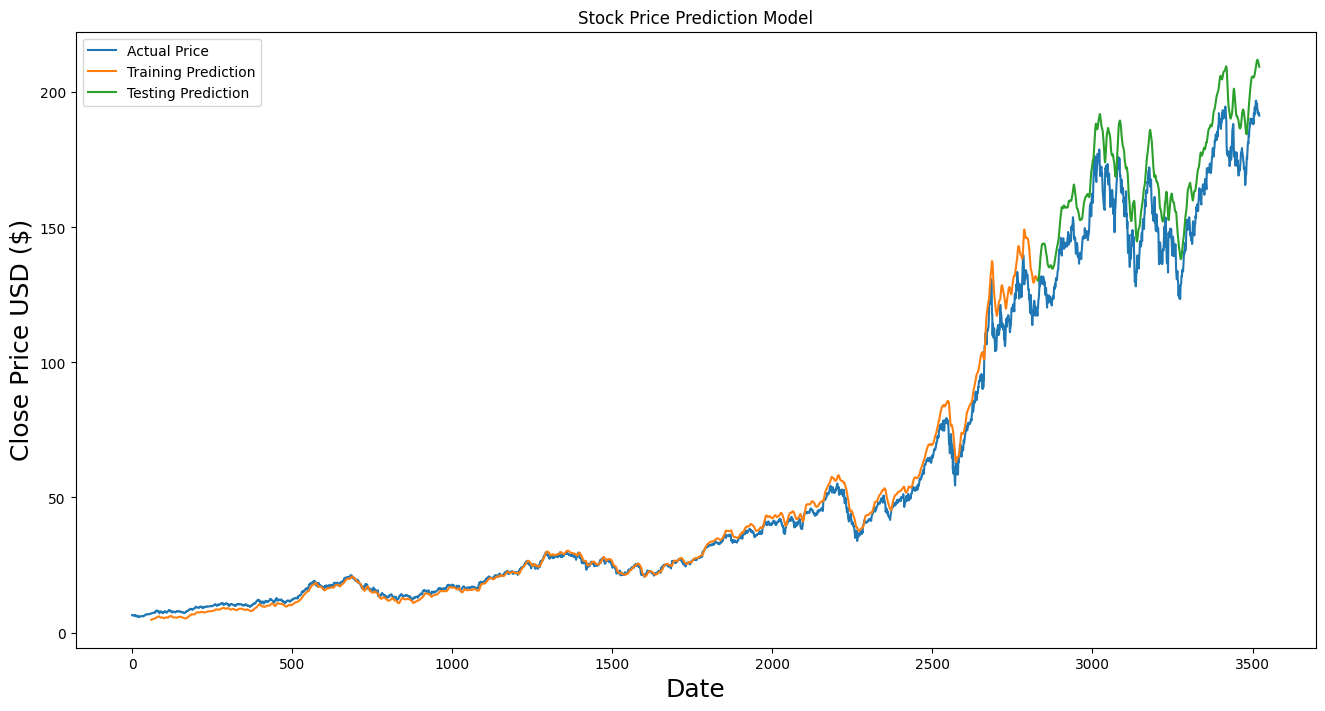

In [14]:
# 9. Visualize Results
plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# Prepare empty arrays for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[SEQ_LENGTH:train_size + SEQ_LENGTH, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[train_size + SEQ_LENGTH:, :] = test_predict

plt.plot(scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(train_predict_plot, label='Training Prediction')
plt.plot(test_predict_plot, label='Testing Prediction')
plt.legend(loc='upper left')
plt.show()
